***TRAINING***

**Cell 1: Capped Training and Evaluation**

In [ ]:
from pathlib import Path
import json
import numpy as np
import scipy.sparse as sp
import lightgbm as lgb
import time, gc

'''Φορτώνω τα Χ/Y parts και τις ετικέτες'''

# Βάσεις paths (ίδιες με τα προηγούμενα)
BASE = Path.home() / "Desktop" / "Malware Project"
VEC = BASE / "data" / "behavior_vectors_paper"

# Νέος φάκελος για τα μοντέλα
MODELS_DIR = VEC / "models_capped"
MODELS_DIR.mkdir(exist_ok=True)

# VARIANT επιλογή
#VARIANT = "capped"

with open(VEC / "label_map_balanced.json", "r") as f:
    label_names = json.load(f)["labels"]
n_labels = len(label_names)
print("Loaded balanced labels:", n_labels)

# --- Λίστες capped parts (χωρίς x_ prefix στα X) ---
XTRN = sorted(VEC.glob("train_part_capped*.npz"))
YTRN = sorted(VEC.glob("y_train_part_capped*.npy"))
XTE  = sorted(VEC.glob("test_part_capped*.npz"))
YTE  = sorted(VEC.glob("y_test_part_capped*.npy"))

print("Train parts:", len(XTRN), "| Test parts:", len(XTE))


Loaded balanced labels: 64
Train parts: 551 | Test parts: 45


**Cell 2: Class Frequency Analysis & Imbalance check**

In [ ]:
# Εύρεση ειδών malware (ονόματα κλάσεων) + μετρήσεις συχνοτήτων

from pathlib import Path
import json, numpy as np
import pandas as pd

# 1) Διαβάζουμε τα ονόματα κλάσεων από το label_map_balanced.json
with open(VEC / "label_map_balanced.json", "r") as f:
    lm = json.load(f)

# Υποστηρίζει είτε λίστα "labels" είτε dict {index->name}
if isinstance(lm, dict) and "labels" in lm and isinstance(lm["labels"], list):
    label_names = lm["labels"]
elif isinstance(lm, dict):
    # π.χ. {"0": "trojan", "1": "ransomware", ...}
    # ταξινόμηση με βάση το ακέραιο index-κλειδί
    label_names = [v for k, v in sorted(lm.items(), key=lambda x: int(x[0]))]
else:
    raise ValueError("Μη αναμενόμενη δομή label_map_balanced.json")

n_labels = len(label_names)
print(f"Loaded {n_labels} labels.")
print("Labels (index → name):")
for i, name in enumerate(label_names):
    print(f"{i:02d} → {name}")

# 2) Μαζεύουμε όλα τα y (train + test) για να μετρήσουμε συχνότητες
y_paths = sorted((VEC).glob("y_train_part_capped*.npy")) + \
          sorted((VEC).glob("y_test_part_capped*.npy"))
if not y_paths:
    raise FileNotFoundError("Δεν βρέθηκαν αρχεία y_*_part_capped*.npy κάτω από το VEC.")

counts = np.zeros(n_labels, dtype=np.int64)

for yp in y_paths:
    y = np.load(yp, allow_pickle=False)
    # Υποστήριξη είτε single-label (ακέραιοι 0..n_labels-1) είτε multi-label (one-hot)
    if y.ndim == 1:
        # single-label
        c = np.bincount(y, minlength=n_labels)
        counts += c
    elif y.ndim == 2 and y.shape[1] == n_labels:
        # multi-label (one-hot / multi-hot)
        counts += y.sum(axis=0).astype(np.int64)
    else:
        raise ValueError(f"Μη αναμενόμενο shape για {yp}: {y.shape}")

# 3) DataFrame με ονόματα κλάσεων και counts
total = counts.sum() if counts.sum() > 0 else 1
df_counts = pd.DataFrame({
    "class_index": np.arange(n_labels),
    "class_name": label_names,
    "count": counts,
    "percent": (counts / total) * 100.0
}).sort_values("count", ascending=False).reset_index(drop=True)

# 4) Εμφάνιση σύνοψης
print("\n=== Σύνολο κλάσεων:", n_labels, "===")
print(df_counts.head(20))  # Top-20 για γρήγορη ματιά

# 5) Προαιρετικά: αποθήκευση πλήρους λίστας σε CSV
out_csv = VEC / "label_counts_capped.csv"
df_counts.to_csv(out_csv, index=False)
print(f"\nΑποθήκευσα πλήρη λίστα στο: {out_csv}")


Loaded 64 labels.
Labels (index → name):
00 → adware
01 → antiav
02 → antifw
03 → autorun
04 → backdoor
05 → banker
06 → bho
07 → binder
08 → blocker
09 → bundler
10 → clicker
11 → coinminer
12 → constructor
13 → cryptor
14 → ddos
15 → dialer
16 → downloader
17 → dropper
18 → email
19 → exploit
20 → fakealert
21 → fakeantivirus
22 → flooder
23 → fraud
24 → ftp
25 → gamehack
26 → gamethief
27 → hacktool
28 → hoax
29 → hotbar
30 → injector
31 → installer
32 → ircbot
33 → joke
34 → keygen
35 → keylogger
36 → lockscreen
37 → net
38 → nettool
39 → nuker
40 → packed
41 → passwordstealer
42 → patcher
43 → porn
44 → proxy
45 → pua
46 → rahack
47 → ransom
48 → rat
49 → riskware
50 → rootkit
51 → screensaver
52 → selfdel
53 → servstart
54 → spam
55 → spyware
56 → startpage
57 → stealer
58 → toolbar
59 → vbinject
60 → virtool
61 → virus
62 → webtoolbar
63 → worm

=== Σύνολο κλάσεων: 64 ===
    class_index       class_name  count   percent
0             0           adware  72560  4.249072
1       

In [ ]:
'''
# Ασφάλειες
assert len(XTRN) == len(YTRN) and len(XTRN) > 0, "Δεν βρέθηκαν train capped parts ή δεν ταιριάζουν τα πλήθη!"
assert len(XTE)  == len(YTE)  and len(XTE)  > 0, "Δεν βρέθηκαν test capped parts ή δεν ταιριάζουν τα πλήθη!"

# Δείγματα
print("Example train:", XTRN[0].name, "|", YTRN[0].name)
print("Example test :", XTE[0].name,  "|", YTE[0].name)
'''


Train parts: 551 | Test parts: 45
Example train: train_part_capped000.npz | y_train_part_capped000.npy
Example test : test_part_capped000.npz | y_test_part_capped000.npy


**Cell 3: Validating Balanced Y Files & Matching with Features**

In [ ]:
# Robust finder για ORIGINAL X + BALANCED Y (όχι capped) 
from pathlib import Path

def pick_first_nonempty(patterns):
    for pat in patterns:
        hits = sorted(VEC.glob(pat))
        # φίλτρο να μην πάρουμε capped εκδόσεις
        hits = [p for p in hits if "_capped" not in p.name]
        if len(hits) > 0:
            return hits
    return []


XTRN = pick_first_nonempty(["x_train_part*.npz", "train_part*.npz"])
XTE  = pick_first_nonempty(["x_test_part*.npz",  "test_part*.npz"])

# Balanced Y 
YTRN_BAL = sorted(VEC.glob("y_train_part_balanced*.npy"))
YTE_BAL  = sorted(VEC.glob("y_test_part_balanced*.npy"))

print("Train parts (X):", len(XTRN), "| Test parts (X):", len(XTE))
print("Balanced Y      :", len(YTRN_BAL), "(train) |", len(YTE_BAL), "(test)")

# Ασφάλειες
assert len(XTRN) > 0 and len(XTRN) == len(YTRN_BAL), \
    "Έλεγξε ότι υπάρχουν και ταιριάζουν τα X train parts με τα y_train_part_balanced*.npy"
assert len(XTE)  > 0 and len(XTE)  == len(YTE_BAL), \
    "Έλεγξε ότι υπάρχουν και ταιριάζουν τα X test parts με τα y_test_part_balanced*.npy"

print("Example train:", XTRN[0].name, "|", YTRN_BAL[0].name)
print("Example test :", XTE[0].name,  "|", YTE_BAL[0].name)


Train parts (X): 551 | Test parts (X): 45
Balanced Y      : 551 (train) | 45 (test)
Example train: train_part000.npz | y_train_part_balanced000.npy
Example test : test_part000.npz | y_test_part_balanced000.npy


**Cell 4: Multi-Label Imbalance Analysis & Cap Calculation**

In [18]:
# Μετράμε positives ανά label στο balanced TRAIN
pos_train = np.zeros(n_labels, dtype=np.int64)
rows_train = 0
for yp in YTRN_BAL:
    y = np.load(yp, allow_pickle=False)  # (rows, n_labels) int8
    pos_train += y.sum(axis=0).astype(np.int64)
    rows_train += y.shape[0]

min_pos = int(pos_train[pos_train > 0].min())
cap_train = 100 * max(1, min_pos)   # "no more than 100× of the min" στο TRAIN

print("Min positives per label:", min_pos, "| cap_train:", cap_train)


Min positives per label: 725 | cap_train: 72500


**Cell 5: Proportional Positive Sampling per label**

In [ ]:
from math import ceil
rng = np.random.default_rng(12345) # σταθερό seed για αναπαραγωγιμότητα

NEG_POS_RATIO = 3     # πόσα negatives ανά positive (ανά label)
VAL_FRACTION  = 0.1   # 10% validation per-label

def plan_per_part_for_label(label_idx: int, cap_pos: int):
    """Επιστρέφει ανά part πόσα POS(itive) θα κρατήσουμε για το συγκεκριμένο label."""
    pos_counts = []
    for yp in YTRN_BAL:
        y = np.load(yp, allow_pickle=False)
        pos_counts.append(int(y[:, label_idx].sum()))
    pos_counts = np.array(pos_counts, dtype=np.int64)

    total_pos = int(pos_counts.sum())
    keep_total = min(total_pos, cap_pos)

    if total_pos == 0:
        return np.zeros(len(YTRN_BAL), dtype=np.int64)

    # αναλογική κατανομή + στρογγυλοποιήσεις
    frac = pos_counts / total_pos
    plan = np.floor(frac * keep_total).astype(np.int64)
    # διανομή του υπολοίπου
    short = int(keep_total - plan.sum())
    if short > 0:
        order = np.argsort(- (frac - plan/keep_total))  # μοιρασε στα "αναλογικά πιο πλούσια"
        for i in order[:short]:
            plan[i] += 1
    return plan  # ανά part πόσα POS


In [ ]:
'''import scipy.sparse as sp
import numpy as np

def part_paths(i: int, split: str = "train"):
    if split == "train":
        return XTRN[i], YTRN[i]
    else:
        return XTE[i], YTE[i]

def load_part(i: int, split: str = "train"):
    Xp, Yp = part_paths(i, split)
    X = sp.load_npz(Xp)
    Y = np.load(Yp, allow_pickle=False).astype(np.int8)
    return X, Y'''


**Cell 6: Per-Label Balanced LightGBM Training with F1-Optimized Threshold Selection**

In [ ]:
MODELS_DIR = VEC / "models_perlabel_capped"
MODELS_DIR.mkdir(exist_ok=True)
THRESH_PATH = VEC / "per_label_thresholds.json"   # θα το γράψουμε στο τέλος

def model_path_for(i: int) -> Path:
    return MODELS_DIR / f"lgb_label_{i:03d}.txt"

def build_dataset_for_label(label_idx: int, pos_plan_per_part):
    X_list, y_list = [], []
    for pi, (xp, yp) in enumerate(zip(XTRN, YTRN_BAL)):
        Y = np.load(yp, allow_pickle=False)        # (rows, n_labels)
        X = sp.load_npz(xp)                        # csr

        y_col = Y[:, label_idx].astype(np.int8)
        pos_idx = np.flatnonzero(y_col == 1)
        neg_idx = np.flatnonzero(y_col == 0)

        # πόσα POS απ' αυτό το part;
        k_pos = int(pos_plan_per_part[pi])
        if k_pos > 0 and len(pos_idx) > 0:
            pos_pick = rng.choice(pos_idx, size=min(k_pos, len(pos_idx)), replace=False)
        else:
            pos_pick = np.array([], dtype=np.int64)

        # NEG sample (ratio)
        k_neg = int(min(len(neg_idx), NEG_POS_RATIO * max(1, len(pos_pick))))
        neg_pick = rng.choice(neg_idx, size=k_neg, replace=False) if k_neg > 0 else np.array([], dtype=np.int64)

        pick = np.concatenate([pos_pick, neg_pick])
        if pick.size == 0:
            continue

        # subset
        X_list.append(X[pick])
        y_list.append(y_col[pick])

        del X, Y
        gc.collect()

    if not X_list:
        return None, None

    X_all = sp.vstack(X_list).tocsr()
    y_all = np.concatenate(y_list).astype(np.int8)

    # shuffle
    order = rng.permutation(X_all.shape[0])
    X_all = X_all[order]
    y_all = y_all[order]

    # split train/val
    n_val = int(ceil(VAL_FRACTION * X_all.shape[0]))
    X_val = X_all[:n_val]; y_val = y_all[:n_val]
    X_tr  = X_all[n_val:]; y_tr  = y_all[n_val:]

    return (X_tr, y_tr, X_val, y_val)

def train_one_label(label_idx: int, cap_pos: int):
    name = label_names[label_idx]
    plan = plan_per_part_for_label(label_idx, cap_pos)
    X_tr, y_tr, X_val, y_val = build_dataset_for_label(label_idx, plan)
    if X_tr is None:
        print(f"[{label_idx:03d}] '{name}': no data — skipped")
        return None

    params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": 0.05,
        "num_leaves": 31,
        "max_bin": 63,
        "feature_fraction": 0.7,
        "bagging_fraction": 0.7,
        "bagging_freq": 1,
        "min_data_in_leaf": 50,
        "min_sum_hessian_in_leaf": 1e-3,
        "num_threads": 0,
        "verbose": -1,
        "seed": 2025,
    }

    dtrain = lgb.Dataset(X_tr, label=y_tr, free_raw_data=True)
    dvalid = lgb.Dataset(X_val, label=y_val, reference=dtrain, free_raw_data=True)

    booster = lgb.train(
        params,
        dtrain,
        num_boost_round=200,
        valid_sets=[dvalid],
        valid_names=["valid"],
        callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=25)]
    )

    # Threshold tuning 
    val_prob = booster.predict(X_val, num_iteration=booster.best_iteration)
    thr_grid = np.linspace(0.05, 0.95, 19)
    best_thr, best_f1 = 0.5, -1.0
    for t in thr_grid:
        y_hat = (val_prob >= t).astype(np.int8)
        tp = ((y_hat == 1) & (y_val == 1)).sum()
        fp = ((y_hat == 1) & (y_val == 0)).sum()
        fn = ((y_hat == 0) & (y_val == 1)).sum()
        f1 = 0.0 if (2*tp + fp + fn) == 0 else (2*tp) / (2*tp + fp + fn)
        if f1 > best_f1:
            best_f1, best_thr = f1, float(t)

    booster.save_model(str(model_path_for(label_idx)))
    print(f"[{label_idx:03d}] '{name}'  best_iter={booster.best_iteration}  best_thr={best_thr:.2f}  val_F1={best_f1:.3f}")
    return best_thr

# --- Full training όλων των labels με per-label capping ---
per_label_thr = {}
for li in range(n_labels):
    thr = train_one_label(li, cap_train)
    if thr is not None:
        per_label_thr[str(li)] = thr

# σώσε τα thresholds
with open(THRESH_PATH, "w") as f:
    json.dump({"thresholds": per_label_thr, "labels": label_names}, f, indent=2)
print("Saved per-label thresholds ->", THRESH_PATH)


Training until validation scores don't improve for 20 rounds
[25]	valid's auc: 0.976026
[50]	valid's auc: 0.981321
[75]	valid's auc: 0.98454
[100]	valid's auc: 0.986348
[125]	valid's auc: 0.987708
[150]	valid's auc: 0.988641
[175]	valid's auc: 0.989266
[200]	valid's auc: 0.98982
Did not meet early stopping. Best iteration is:
[200]	valid's auc: 0.98982
[000] 'adware'  best_iter=200  best_thr=0.50  val_F1=0.914
Training until validation scores don't improve for 20 rounds
[25]	valid's auc: 0.970332
[50]	valid's auc: 0.979824
[75]	valid's auc: 0.984809
[100]	valid's auc: 0.987842
[125]	valid's auc: 0.989731
[150]	valid's auc: 0.991032
[175]	valid's auc: 0.99207
[200]	valid's auc: 0.992889
Did not meet early stopping. Best iteration is:
[200]	valid's auc: 0.992889
[001] 'antiav'  best_iter=200  best_thr=0.35  val_F1=0.947
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid's auc: 0.999633
[002] 'antifw'  best_iter=3  best_thr=0.30  val_

**Cell 7: Test Evaluation: Micro/Macro/Weighted Metrics & AUC**

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# φόρτωσε thresholds από training
with open(THRESH_PATH, "r") as f:
    thr_info = json.load(f)
thr_map = {int(k): float(v) for k, v in thr_info["thresholds"].items()}

# μαζεύουμε y_true, y_prob (per-label), y_pred (με per-label threshold)
true_all, prob_all, pred_all = [], [], []

for i in range(len(XTE)):
    X = sp.load_npz(XTE[i])
    Y = np.load(YTE_BAL[i], allow_pickle=False).astype(np.int8)
    true_all.append(Y)

    probs = np.zeros((X.shape[0], n_labels), dtype=np.float32)
    preds = np.zeros((X.shape[0], n_labels), dtype=np.int8)

    for li in range(n_labels):
        booster = lgb.Booster(model_file=str(model_path_for(li)))
        p = booster.predict(X)
        probs[:, li] = p
        thr = thr_map.get(li, 0.5)
        preds[:, li] = (p >= thr).astype(np.int8)

    prob_all.append(probs)
    pred_all.append(preds)
    print(f"[test] part {i+1}/{len(XTE)} done")

y_true = np.vstack(true_all)
y_prob = np.vstack(prob_all)
y_pred = np.vstack(pred_all)
# συνοπτικός πίνακας
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="micro", zero_division=0
)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

from sklearn.metrics import roc_auc_score
import numpy as np

# AUCs (μπορεί να πετάξει ValueError όταν κάποιο label στο test έχει μόνο μία κλάση)
try:
    auc_micro = roc_auc_score(y_true, y_prob, average="micro")
except ValueError:
    auc_micro = np.nan

try:
    auc_macro = roc_auc_score(y_true, y_prob, average="macro")
except ValueError:
    auc_macro = np.nan

try:
    auc_weighted = roc_auc_score(y_true, y_prob, average="weighted")
except ValueError:
    auc_weighted = np.nan

summary = pd.DataFrame(
    {
        "Micro":    [precision_micro,  recall_micro,  f1_micro,  auc_micro],
        "Macro":    [precision_macro,  recall_macro,  f1_macro,  auc_macro],
        "Weighted": [precision_weighted, recall_weighted, f1_weighted, auc_weighted],
    },
    index=["Precision", "Recall", "F1-score", "AUC"],
).round(4)

display(summary)

# --------- SAVE ----------
from pathlib import Path
import json

# Αν έχεις RESULTS_DIR (π.χ. results_capped_eval) χρησιμοποίησέ το. Αλλιώς γράφε στο VEC.
OUT_DIR = (RESULTS_DIR if "RESULTS_DIR" in globals() else VEC)
OUT_DIR = Path(OUT_DIR)
OUT_DIR.mkdir(exist_ok=True, parents=True)

csv_path  = OUT_DIR / "overall_metrics_perlabel_capped.csv"
json_path = OUT_DIR / "overall_metrics_perlabel_capped.json"

summary.to_csv(csv_path)
summary.to_json(json_path, orient="index", indent=2)

print("✅ Saved summary CSV ->", csv_path)
print("✅ Saved summary JSON ->", json_path)

'''# συνοπτικός πίνακας
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average="micro", zero_division=0)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)

auc_micro = roc_auc_score(y_true, y_prob, average="micro")
auc_macro = roc_auc_score(y_true, y_prob, average="macro")

summary = pd.DataFrame({
    "Micro":    [precision_micro, recall_micro, f1_micro, auc_micro],
    "Macro":    [precision_macro, recall_macro, f1_macro, auc_macro],
    "Weighted": [precision_weighted, recall_weighted, f1_weighted, None]
}, index=["Precision", "Recall", "F1-score", "AUC"]).round(4)

display(summary)


# save
summary.to_csv(VEC / "overall_metrics_perlabel_capped.csv")
summary.to_json(VEC / "overall_metrics_perlabel_capped.json", orient="index", indent=2)
print("Saved:", VEC / "overall_metrics_perlabel_capped.csv")
'''

[test] part 1/45 done
[test] part 2/45 done
[test] part 3/45 done
[test] part 4/45 done
[test] part 5/45 done
[test] part 6/45 done
[test] part 7/45 done
[test] part 8/45 done
[test] part 9/45 done
[test] part 10/45 done
[test] part 11/45 done
[test] part 12/45 done
[test] part 13/45 done
[test] part 14/45 done
[test] part 15/45 done
[test] part 16/45 done
[test] part 17/45 done
[test] part 18/45 done
[test] part 19/45 done
[test] part 20/45 done
[test] part 21/45 done
[test] part 22/45 done
[test] part 23/45 done
[test] part 24/45 done
[test] part 25/45 done
[test] part 26/45 done
[test] part 27/45 done
[test] part 28/45 done
[test] part 29/45 done
[test] part 30/45 done
[test] part 31/45 done
[test] part 32/45 done
[test] part 33/45 done
[test] part 34/45 done
[test] part 35/45 done
[test] part 36/45 done
[test] part 37/45 done
[test] part 38/45 done
[test] part 39/45 done
[test] part 40/45 done
[test] part 41/45 done
[test] part 42/45 done
[test] part 43/45 done
[test] part 44/45 do

/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,Micro,Macro,Weighted
Precision,0.1863,0.1913,0.4368
Recall,0.4642,0.5873,0.4642
F1-score,0.2659,0.2115,0.3879
AUC,0.8637,NaN,0.8025


✅ Saved summary CSV -> /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/results_capped_eval/overall_metrics_perlabel_capped.csv
✅ Saved summary JSON -> /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/results_capped_eval/overall_metrics_perlabel_capped.json


'# συνοπτικός πίνακας\nprecision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average="micro", zero_division=0)\nprecision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)\nprecision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)\n\nauc_micro = roc_auc_score(y_true, y_prob, average="micro")\nauc_macro = roc_auc_score(y_true, y_prob, average="macro")\n\nsummary = pd.DataFrame({\n    "Micro":    [precision_micro, recall_micro, f1_micro, auc_micro],\n    "Macro":    [precision_macro, recall_macro, f1_macro, auc_macro],\n    "Weighted": [precision_weighted, recall_weighted, f1_weighted, None]\n}, index=["Precision", "Recall", "F1-score", "AUC"]).round(4)\n\ndisplay(summary)\n\n\n# save\nsummary.to_csv(VEC / "overall_metrics_perlabel_capped.csv")\nsummary.to_json(VEC / "overall_metrics_perlabel_capped.json

## Για καλύτερα μετρικά αποτελέσματα

**Cell 8: Create a Balanced Validation Set Using Robust Stratified Split**


In [ ]:
# Δημιουργία validation set (20%) από τα capped train parts (robust stratify) 

from pathlib import Path
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import warnings

XTRN_CAP = sorted(VEC.glob("train_part_capped*.npz"))
YTRN_CAP = sorted(VEC.glob("y_train_part_capped*.npy"))

val_X_list, val_Y_list = [], []

for xp, yp in zip(XTRN_CAP, YTRN_CAP):
    Xp = sp.load_npz(xp)
    Yp = np.load(yp, allow_pickle=False).astype(np.int8)

    idx = np.arange(Xp.shape[0])

    # πόσα labels έχει κάθε δείγμα
    strat_raw = Yp.sum(axis=1) # τα μετατρέπω σε μια συνοπτική μορφή
    strat_raw = np.asarray(strat_raw).reshape(-1)   # 1D

    # binning: 0, 1, 2, >=3
    strat_binned = np.clip(strat_raw, 0, 3)

    # αν κάποιο bin έχει <2 δείγματα, δεν κάνουμε stratify (fallback)
    vals, counts = np.unique(strat_binned, return_counts=True)
    use_strat = (len(vals) >= 2) and np.all(counts >= 2)

    # αν δεν υπάρχουν αρκετά labels σε κάποιο part προβάλλεται warning και γίνεται fallback σε τυχαίο split
    # και τα νέα validation κομμάτια ενώνονται σ ένα μεγάλο validation set
    if not use_strat:
        warnings.warn(
            f"No safe stratify for {xp.name} (bins {dict(zip(vals, counts))}). "
            "Falling back to non-stratified split."
        )
        strat_arg = None
    else:
        strat_arg = strat_binned

    train_idx, val_idx = train_test_split(
        idx, test_size=0.2, random_state=42, stratify=strat_arg
    )

    val_X_list.append(Xp[val_idx])
    val_Y_list.append(Yp[val_idx])

X_val = sp.vstack(val_X_list).tocsr()
Y_val = np.vstack(val_Y_list).astype(np.int8)
print("Validation shape:", X_val.shape, Y_val.shape)


/var/folders/p9/2dknt7qd7vvdybk48l4dvk540000gn/T/ipykernel_28426/464652168.py:32: UserWarning: No safe stratify for train_part_capped015.npz (bins {np.int64(0): np.int64(1), np.int64(1): np.int64(1515), np.int64(2): np.int64(855), np.int64(3): np.int64(90)}). Falling back to non-stratified split.
  warnings.warn(
/var/folders/p9/2dknt7qd7vvdybk48l4dvk540000gn/T/ipykernel_28426/464652168.py:32: UserWarning: No safe stratify for train_part_capped018.npz (bins {np.int64(0): np.int64(1), np.int64(1): np.int64(1479), np.int64(2): np.int64(845), np.int64(3): np.int64(88)}). Falling back to non-stratified split.
  warnings.warn(
/var/folders/p9/2dknt7qd7vvdybk48l4dvk540000gn/T/ipykernel_28426/464652168.py:32: UserWarning: No safe stratify for train_part_capped028.npz (bins {np.int64(0): np.int64(1), np.int64(1): np.int64(1865), np.int64(2): np.int64(737), np.int64(3): np.int64(84)}). Falling back to non-stratified split.
  warnings.warn(
/var/folders/p9/2dknt7qd7vvdybk48l4dvk540000gn/T/ipyker

Validation shape: (246831, 2381) (246831, 64)


**Cell 9: Calibration (Platt Scaling) + Optimal Threshold Selection from PR Curve**

In [ ]:
# Calibration (Platt scaling) + εύρεση threshold από καμπύλη precision - recall (PR curve)

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import joblib
import json

CAL_DIR = RESULTS_DIR / "calibration"
CAL_DIR.mkdir(exist_ok=True)

cal_thresholds = {}
cal_models = {}

# Υπολογίζουμε πιθανότητες για όλα τα labels στο validation
val_prob = np.zeros((X_val.shape[0], n_labels), dtype=np.float32)

for li in range(n_labels):
    booster = lgb.Booster(model_file=str(model_path_for(li)))
    val_prob[:, li] = booster.predict(X_val)

# Κάνουμε calibration + βρίσκουμε best threshold ανά label
for li in range(n_labels):
    yv = Y_val[:, li]
    pv = val_prob[:, li]

    if len(np.unique(yv)) < 2:
        cal_thresholds[li] = 0.5
        continue

    lr = LogisticRegression(max_iter=1000)
    lr.fit(pv.reshape(-1,1), yv)
    pv_cal = lr.predict_proba(pv.reshape(-1,1))[:,1]

    prec, rec, thr = precision_recall_curve(yv, pv_cal)
    f1 = 2*prec*rec / (prec + rec + 1e-12)
    best_idx = f1.argmax()
    best_thr = thr[max(0, min(best_idx, len(thr)-1))]

    cal_models[li] = lr
    cal_thresholds[li] = float(best_thr)

    joblib.dump(lr, CAL_DIR / f"platt_label_{li:03d}.joblib")

# Αποθήκευση thresholds
with open(CAL_DIR / "calibrated_thresholds.json", "w") as f:
    json.dump({str(k): v for k,v in cal_thresholds.items()}, f, indent=2)

print("✅ Saved calibrated thresholds & models in", CAL_DIR)


✅ Saved calibrated thresholds & models in /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/results_capped_eval/calibration


**Cell 10: Global Beta Threshold Tuning using Validation (Macro Precision & Recall Optimization)**


In [ ]:
# Tune beta so that both Macro-Precision and Macro-Recall go up 

import numpy as np
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

# βάζω εδώ τα "παλιά" macro baseline (από το προηγούμενο run πριν το calibration)
P0_macro = 0.1913   # παλιό Macro Precision
R0_macro = 0.5873   #  παλιό Macro Recall

def thresholds_for_beta(pv_cal_matrix, Y_val, beta=1.0):
    """Βρίσκει per-label thresholds που μεγιστοποιούν Fβ πάνω στο validation (με calibrated probs)."""
    n_labels = pv_cal_matrix.shape[1]
    thr_map = {}
    eps = 1e-12
    for li in range(n_labels):
        yv = Y_val[:, li]
        pv = pv_cal_matrix[:, li]
        # Αν degenerate (μία κλάση), κράτα 0.5
        if len(np.unique(yv)) < 2:
            thr_map[li] = 0.5
            continue
        prec, rec, thr = precision_recall_curve(yv, pv)
        fbeta = (1+beta**2) * prec * rec / (beta**2 * prec + rec + eps)
        i = int(fbeta.argmax())
        # thr έχει μήκος len(prec)-1 (στοιχίζει με prec[1:], rec[1:])
        thr_sel = thr[max(0, min(i, len(thr)-1))]
        thr_map[li] = float(thr_sel)
    return thr_map

def eval_macro_on_val(pv_cal_matrix, Y_val, thr_map):
    """Επιστρέφει Macro Precision/Recall/F1 σε validation για ένα σύνολο thresholds."""
    y_pred_val = np.zeros_like(Y_val, dtype=np.int8)
    for li, thr in thr_map.items():
        y_pred_val[:, li] = (pv_cal_matrix[:, li] >= thr).astype(np.int8)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        Y_val, y_pred_val, average="macro", zero_division=0
    )
    return p_macro, r_macro, f1_macro

# 1) Υπολόγισε calibrated probs στο validation (pv_cal_matrix)
#    Αν παραπάνω στο Block B δεν κράτησες το pv_cal ανά label, το φτιάχνουμε τώρα:
from sklearn.linear_model import LogisticRegression

val_prob_cal = np.zeros_like(val_prob, dtype=np.float32)
for li in range(n_labels):
    lr = cal_models.get(li, None)
    if lr is None:
        val_prob_cal[:, li] = val_prob[:, li]
    else:
        val_prob_cal[:, li] = lr.predict_proba(val_prob[:, li].reshape(-1,1))[:,1]

# 2) Grid search σε beta
candidates = np.linspace(0.6, 1.6, 11)  # 0.6, 0.7, ..., 1.6
best = None
best_rec = {}

for beta in candidates:
    thr_map = thresholds_for_beta(val_prob_cal, Y_val, beta=beta)
    pM, rM, fM = eval_macro_on_val(val_prob_cal, Y_val, thr_map)

    # Constraint: και τα δύο >= baseline
    if (pM >= P0_macro) and (rM >= R0_macro):
        if (best is None) or (fM > best[2]):
            best = (beta, thr_map, fM)
            best_rec = {"MacroPrecision": pM, "MacroRecall": rM, "MacroF1": fM}

print("Βρέθηκε:" if best else "Δεν βρέθηκε beta που να βελτιώνει και τα δύο.")
if best:
    print(f"  beta={best[0]:.2f} | Macro P={best_rec['MacroPrecision']:.4f} | "
          f"Macro R={best_rec['MacroRecall']:.4f} | Macro F1={best_rec['MacroF1']:.4f}")

# Αν δεν βρέθηκε τέτοιο beta, πάρε το καλύτερο Macro-F1 χωρίς constraint
if best is None:
    fallback = None
    for beta in candidates:
        thr_map = thresholds_for_beta(val_prob_cal, Y_val, beta=beta)
        pM, rM, fM = eval_macro_on_val(val_prob_cal, Y_val, thr_map)
        if (fallback is None) or (fM > fallback[2]):
            fallback = (beta, thr_map, fM, pM, rM)
    best = (fallback[0], fallback[1], fallback[2])
    print(f"Fallback beta={fallback[0]:.2f} | Macro P={fallback[3]:.4f} | "
          f"Macro R={fallback[4]:.4f} | Macro F1={fallback[2]:.4f}")

# Κράτα τα thresholds του επιλεγμένου beta για TEST
beta_chosen, thr_map_beta, _ = best
cal_thresholds = {int(k): float(v) for k, v in cal_thresholds.items()}  # από πριν (best-F1=1.0)
cal_thresholds.update(thr_map_beta)  # αντικατάστησε με τα “beta-tuned” thresholds
print(f"Χρησιμοποιώ beta={beta_chosen:.2f} για τα TEST thresholds.")


Βρέθηκε:
  beta=1.00 | Macro P=0.7644 | Macro R=0.7609 | Macro F1=0.7562
Χρησιμοποιώ beta=1.00 για τα TEST thresholds.


**Cell 11: Test evaluation + new metrics**

In [ ]:
#  Εφαρμογή calibration + νέος υπολογισμός metrics στο TEST 

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import numpy as np
import pandas as pd

# Calibration στο test set
# υπολογίζω calibrated probabilities στο Test για κάθε label,
# φορτώνω το αντίστοιχο Platt LR και μετατρέπω το prob του LightGBM σε καλιμπραρισμένο
y_prob_cal = np.zeros_like(y_prob, dtype=np.float32)
for li in range(n_labels):
    lr = cal_models.get(li, None)
    if lr is None:
        y_prob_cal[:, li] = y_prob[:, li]
    else:
        y_prob_cal[:, li] = lr.predict_proba(y_prob[:, li].reshape(-1,1))[:,1]
# παράγω προβλέψεις 0/1 στο Test εφαρμόζοντας calibrated threshold per label
y_pred_cal = np.zeros_like(y_pred, dtype=np.int8)
for li in range(n_labels):
    thr = cal_thresholds.get(li, 0.5)
    y_pred_cal[:, li] = (y_prob_cal[:, li] >= thr).astype(np.int8)

# AUCs 

#  Micro AUC με probabilities
try:
    auc_micro = roc_auc_score(y_true, y_prob_cal, average="micro")
except ValueError:
    auc_micro = np.nan

# Macro AUC ως nan-mean από per-label AUC
auc_per_label = []
nan_auc_labels = []
for li in range(n_labels):
    y_t = y_true[:, li]
    y_s = y_prob_cal[:, li]  # continuous scores
    # Αν δεν υπάρχουν και οι δύο κλάσεις στο label, βάζουμε NaN
    if np.unique(y_t).size < 2:
        auc_per_label.append(np.nan)
        nan_auc_labels.append(li)
    else:
        auc_per_label.append(roc_auc_score(y_t, y_s))

auc_macro = float(np.nanmean(auc_per_label))  # αγνοεί τα NaN

# Weighted AUC κανονικά με probabilities
try:
    auc_weighted = roc_auc_score(y_true, y_prob_cal, average="weighted")
except ValueError:
    auc_weighted = np.nan


summary_cal = pd.DataFrame(
    {
        "Micro":    [p_micro,  r_micro,  f1_micro,  auc_micro],
        "Macro":    [p_macro,  r_macro,  f1_macro,  auc_macro],
        "Weighted": [p_w,      r_w,      f1_w,      auc_weighted],
    },
    index=["Precision", "Recall", "F1-score", "AUC"],
).round(4)

display(summary_cal)

summary_cal.to_csv(RESULTS_DIR / "overall_metrics_perlabel_capped_CAL.csv")
summary_cal.to_json(RESULTS_DIR / "overall_metrics_perlabel_capped_CAL.json", orient="index", indent=2)

print("✅ Saved calibrated summary →", RESULTS_DIR / "overall_metrics_perlabel_capped_CAL.*")


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,Micro,Macro,Weighted
Precision,0.5386,0.4626,0.6648
Recall,0.2926,0.3843,0.2926
F1-score,0.3792,0.3348,0.3685
AUC,0.9125,0.8648,0.8025


✅ Saved calibrated summary → /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/results_capped_eval/overall_metrics_perlabel_capped_CAL.*


**Plots και διαφορα αλλα δεν τα εχω ακομα τελειωσει**

In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, roc_curve, auc

# 0.1 Φάκελος για plots
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# 0.2 Ονόματα labels (fallback αν λείπουν)
try:
    label_names
except NameError:
    label_names = [f"L{idx:02d}" for idx in range(n_labels)]

# 0.3 Υπολογισμός per-label metrics (Precision/Recall/F1/AUC/Support)
per_label = []
nan_auc_labels = []
for li in range(n_labels):
    y_t   = y_true[:, li]
    y_hat = y_pred_cal[:, li]
    y_sc  = y_prob_cal[:, li]  # probabilities/scores
    
    # precision/recall/f1 για το συγκεκριμένο label
    p, r, f1, _ = precision_recall_fscore_support(
        y_t, y_hat, average="binary", zero_division=0
    )
    
    # AUC per label (NaN αν δεν υπάρχουν και οι δύο κλάσεις)
    if np.unique(y_t).size < 2:
        a = np.nan
        nan_auc_labels.append(li)
    else:
        a = roc_auc_score(y_t, y_sc)

    support = int(np.sum(y_t == 1))
    prevalence = support / len(y_t)
    
    per_label.append({
        "label_id": li,
        "label": label_names[li],
        "precision": p,
        "recall": r,
        "f1": f1,
        "auc": a,
        "support_pos": support,
        "prevalence": prevalence
    })

df = pd.DataFrame(per_label).sort_values("f1", ascending=False).reset_index(drop=True)
df.head()


,label_id,label,precision,recall,f1,auc,support_pos,prevalence
0,15,dialer,0.953474,0.989962,0.971376,0.999459,1594,0.007138
1,56,startpage,0.969588,0.971254,0.970421,0.994237,6401,0.028665
2,51,screensaver,0.983673,0.956349,0.969819,0.997864,252,0.001129
3,29,hotbar,0.991903,0.900735,0.944123,0.999921,272,0.001218
4,22,flooder,0.997059,0.890933,0.941013,0.984934,761,0.003408


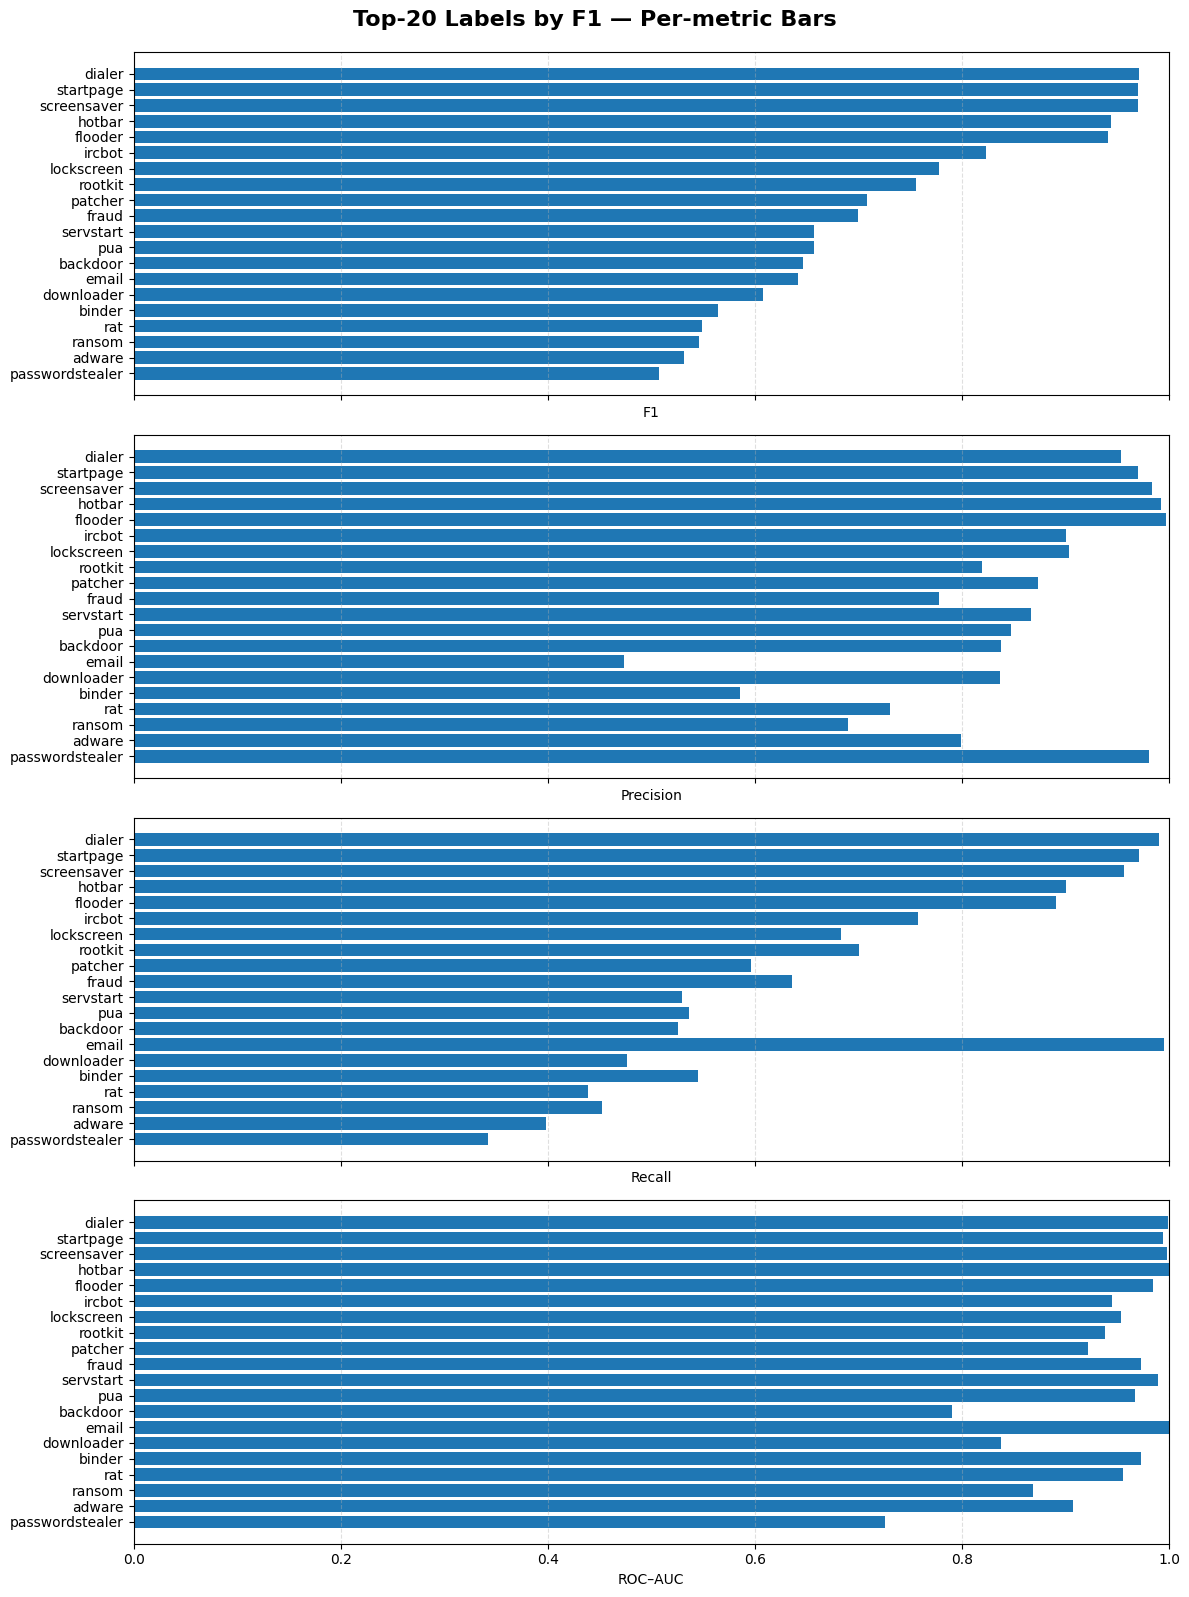

Saved → /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/results_capped_eval/plots/top20_byF1_subplots.png


In [63]:
topN = 20
top_df = df.sort_values("f1", ascending=False).head(topN).copy()
labels_plot = top_df["label"].values

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)  # 4 subplots: F1/Prec/Rec/AUC
plt.suptitle(
    f"Top-{topN} Labels by F1 — Per-metric Bars",
    fontsize=16,
    fontweight="bold",
    y=0.995,           # πιο πάνω στο figure
)


# F1
axes[0].barh(labels_plot, top_df["f1"].values)
axes[0].invert_yaxis()
axes[0].set_xlim(0, 1)
axes[0].set_xlabel("F1")
axes[0].grid(axis="x", linestyle="--", alpha=0.4)

# Precision
axes[1].barh(labels_plot, top_df["precision"].values)
axes[1].invert_yaxis()
axes[1].set_xlim(0, 1)
axes[1].set_xlabel("Precision")
axes[1].grid(axis="x", linestyle="--", alpha=0.4)

# Recall
axes[2].barh(labels_plot, top_df["recall"].values)
axes[2].invert_yaxis()
axes[2].set_xlim(0, 1)
axes[2].set_xlabel("Recall")
axes[2].grid(axis="x", linestyle="--", alpha=0.4)

# AUC (προσοχή σε NaN)
auc_vals = top_df["auc"].fillna(0.5)  # προαιρετικά: NaN→0.5 για οπτικοποίηση
axes[3].barh(labels_plot, auc_vals.values)
axes[3].invert_yaxis()
axes[3].set_xlim(0, 1)
axes[3].set_xlabel("ROC–AUC")
axes[3].grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
out_path = os.path.join(PLOTS_DIR, f"top{topN}_byF1_subplots.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved →", out_path)


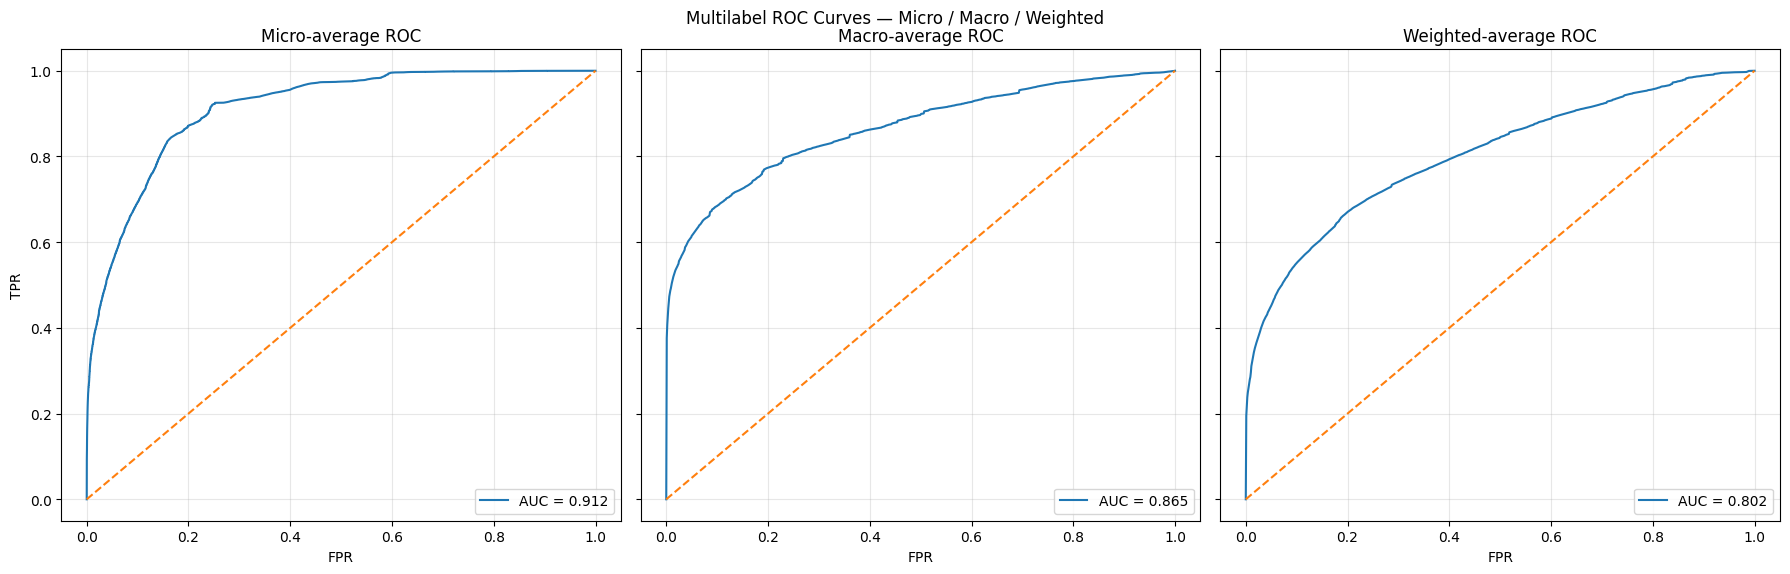

Saved → /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/results_capped_eval/plots/roc_multi_averages.png
Micro AUC   : 0.9125
Macro AUC   : 0.8647
Weighted AUC: 0.8024


In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Φάκελος για αποθήκευση
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# --- 1) MICRO-average ROC ---
# ravel σε όλα τα labels
fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_prob_cal.ravel())
auc_micro = auc(fpr_micro, tpr_micro)  # ισοδύναμο με roc_auc_score(..., average="micro")

# --- 2) MACRO & WEIGHTED-average ROC ---
# Κοινό grid για FPR ώστε να γίνει ο μέσος όρος TPR
fpr_grid = np.linspace(0, 1, 1001)

tprs_macro = []     # θα κρατήσουμε τις διεπιπεδωμένες TPR ανά label
tprs_weighted = []  # ίδιο με macro, αλλά θα εφαρμόσουμε βάρη στο τέλος
weights = []        # βάρη = support_pos (πλήθος θετικών) ανά label
valid_labels = 0

for li in range(n_labels):
    y_t  = y_true[:, li]
    y_sc = y_prob_cal[:, li]
    
    # Αν δεν υπάρχουν και οι δύο κλάσεις, skip
    if np.unique(y_t).size < 2:
        continue
    
    fpr_i, tpr_i, _ = roc_curve(y_t, y_sc)
    # Διεπιπέδωση TPR στο κοινό grid
    tpr_i_interp = np.interp(fpr_grid, fpr_i, tpr_i)
    tpr_i_interp[0] = 0.0  # για καθαρή αρχή
    
    tprs_macro.append(tpr_i_interp)
    tprs_weighted.append(tpr_i_interp)
    weights.append(np.sum(y_t == 1))
    valid_labels += 1

if valid_labels == 0:
    raise RuntimeError("Δεν υπάρχει κανένα label με και τις δύο κλάσεις στο test set.")

# MACRO: απλός μέσος όρος των TPRs
tpr_macro = np.mean(np.vstack(tprs_macro), axis=0)
auc_macro = auc(fpr_grid, tpr_macro)

# WEIGHTED: μέσος όρος TPRs με βάρη = support_pos
weights = np.array(weights, dtype=float)
weights = weights / weights.sum()  # κανονικοποίηση
tprs_weighted_arr = np.vstack(tprs_weighted)
tpr_weighted = np.average(tprs_weighted_arr, axis=0, weights=weights)
auc_weighted = auc(fpr_grid, tpr_weighted)

# --- 3) Plot: 3 subplots (micro/macro/weighted) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
fig.suptitle("Multilabel ROC Curves — Micro / Macro / Weighted", y=0.95)

# Micro
axes[0].plot(fpr_micro, tpr_micro, label=f"AUC = {auc_micro:.3f}")
axes[0].plot([0,1], [0,1], linestyle="--")
axes[0].set_title("Micro-average ROC")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].grid(alpha=0.3)
axes[0].legend(loc="lower right")

# Macro
axes[1].plot(fpr_grid, tpr_macro, label=f"AUC = {auc_macro:.3f}")
axes[1].plot([0,1], [0,1], linestyle="--")
axes[1].set_title("Macro-average ROC")
axes[1].set_xlabel("FPR")
axes[1].grid(alpha=0.3)
axes[1].legend(loc="lower right")

# Weighted
axes[2].plot(fpr_grid, tpr_weighted, label=f"AUC = {auc_weighted:.3f}")
axes[2].plot([0,1], [0,1], linestyle="--")
axes[2].set_title("Weighted-average ROC")
axes[2].set_xlabel("FPR")
axes[2].grid(alpha=0.3)
axes[2].legend(loc="lower right")

plt.tight_layout()
out_path = os.path.join(PLOTS_DIR, "roc_multi_averages.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved →", out_path)
print(f"Micro AUC   : {auc_micro:.4f}")
print(f"Macro AUC   : {auc_macro:.4f}")
print(f"Weighted AUC: {auc_weighted:.4f}")


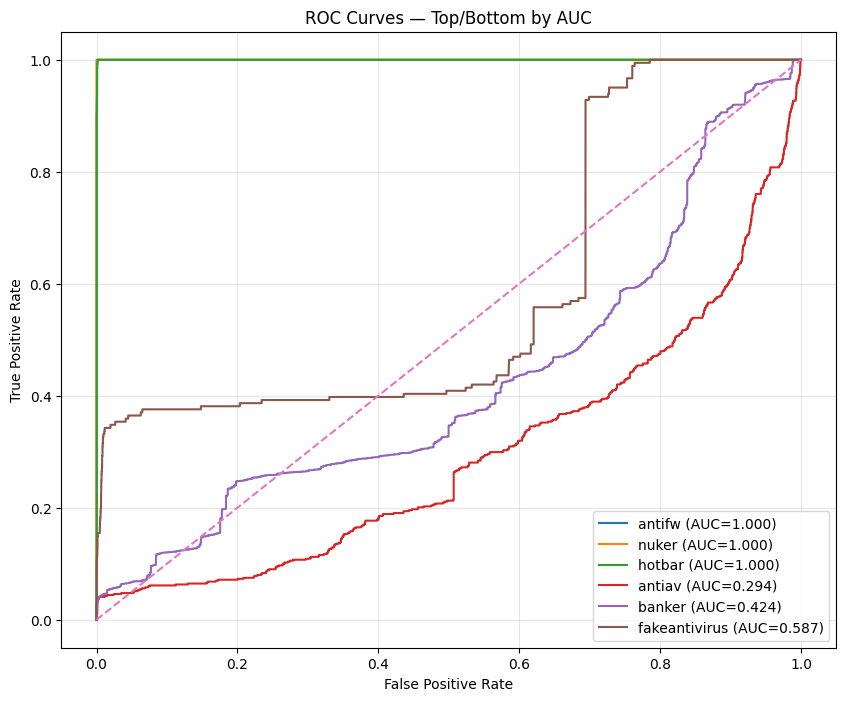

Saved → /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/results_capped_eval/plots/roc_top3_bottom3.png


In [53]:
# Φιλτράρουμε labels με οριστό AUC
df_auc_ok = df.dropna(subset=["auc"]).copy()
if len(df_auc_ok) < 6:
    print("Προειδοποίηση: Λίγα labels με οριστό AUC — θα χρησιμοποιήσω όσα υπάρχουν.")

k = min(3, max(1, len(df_auc_ok)//2))
top_auc = df_auc_ok.sort_values("auc", ascending=False).head(k)
bot_auc = df_auc_ok.sort_values("auc", ascending=True).head(k)
sel = pd.concat([top_auc, bot_auc], axis=0)

plt.figure(figsize=(10, 8))
for _, row in sel.iterrows():
    li = int(row["label_id"])
    y_t  = y_true[:, li]
    y_sc = y_prob_cal[:, li]
    fpr, tpr, _ = roc_curve(y_t, y_sc)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{row['label']} (AUC={auc_val:.3f})")

# Διαγώνιος random
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Top/Bottom by AUC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

out_path = os.path.join(PLOTS_DIR, "roc_top3_bottom3.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved →", out_path)


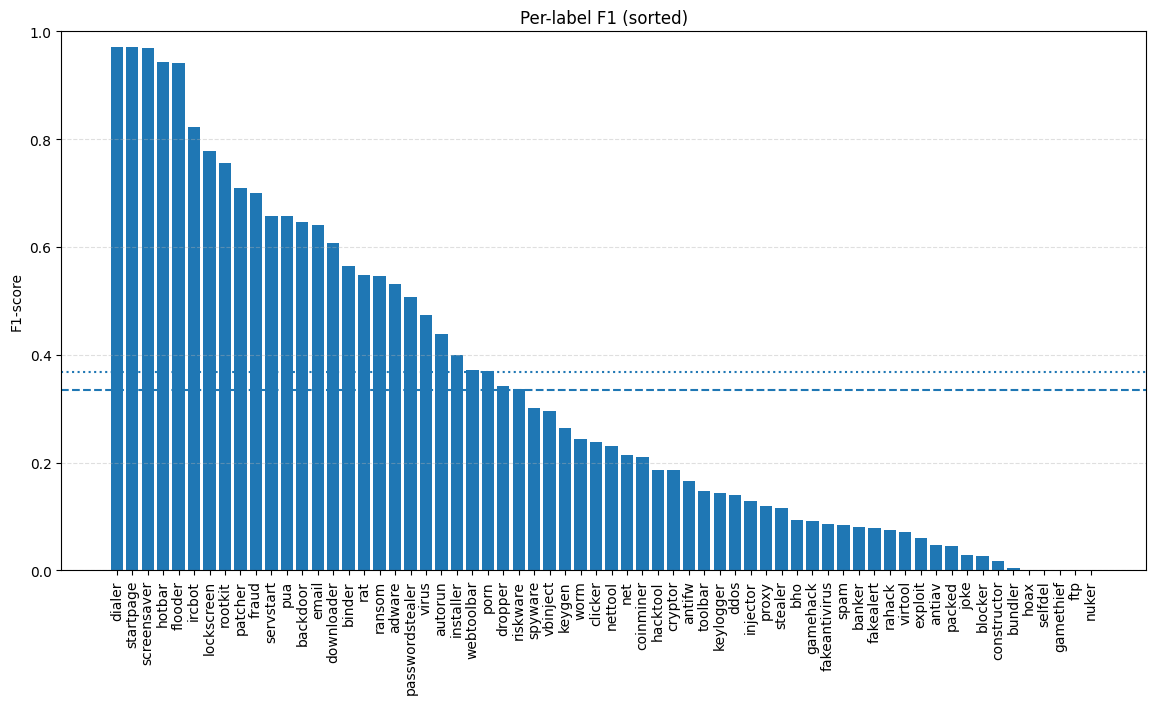

Saved → /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/results_capped_eval/plots/per_label_f1_sorted.png


In [55]:
df_sorted = df.sort_values("f1", ascending=False).copy()


plt.figure(figsize=(14, 7))
plt.bar(df_sorted["label"].values, df_sorted["f1"].values)
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.axhline(f1_macro, linestyle="--")
plt.axhline(f1_w, linestyle=":")
plt.title("Per-label F1 (sorted)")
plt.grid(axis="y", linestyle="--", alpha=0.4)

out_path = os.path.join(PLOTS_DIR, "per_label_f1_sorted.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved →", out_path)


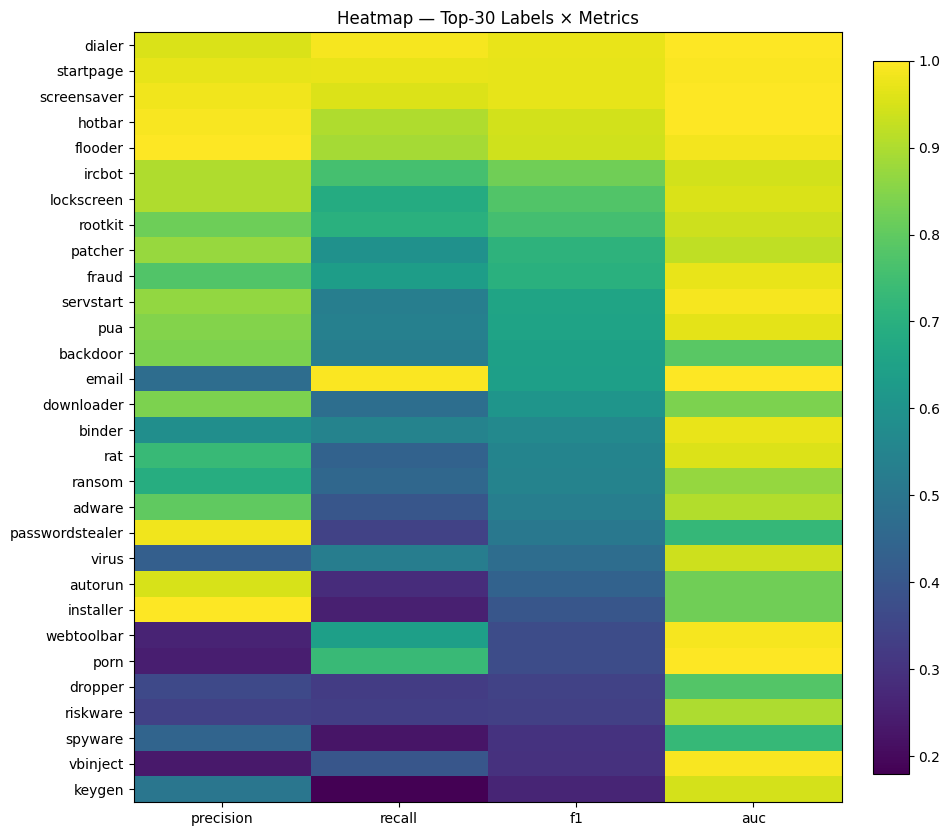

Saved → /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/results_capped_eval/plots/heatmap_top30_metrics.png


In [56]:
topM = 30
cols = ["precision", "recall", "f1", "auc"]

M = df.head(topM)[cols].fillna(0.5).values  # NaN AUC→0.5 για εμφάνιση
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(M, aspect="auto")

ax.set_xticks(range(len(cols)))
ax.set_xticklabels(cols)
ax.set_yticks(range(topM))
ax.set_yticklabels(df.head(topM)["label"].values)
plt.title(f"Heatmap — Top-{topM} Labels × Metrics")
plt.colorbar(im, fraction=0.046, pad=0.04)

out_path = os.path.join(PLOTS_DIR, f"heatmap_top{topM}_metrics.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved →", out_path)


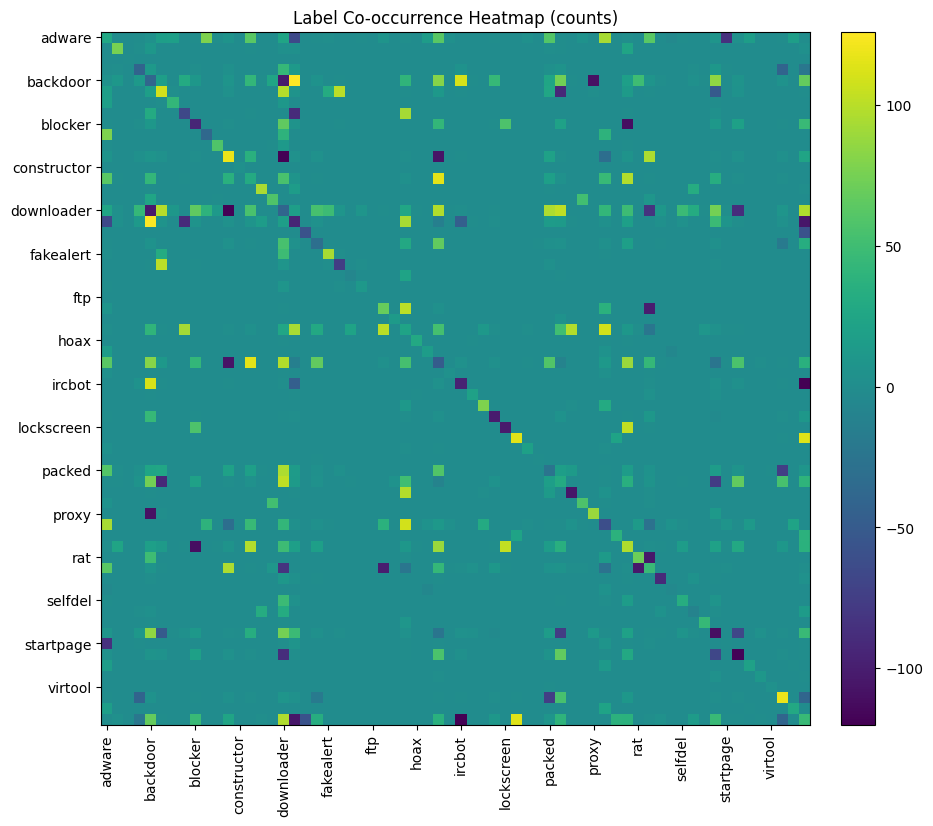

Saved → /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/results_capped_eval/plots/heatmap_label_cooccurrence.png


In [57]:
# 5.1 Συν-εμφάνιση: C[i,j] = πλήθος samples με y_true[:,i]==1 & y_true[:,j]==1
C = (y_true.T @ y_true).astype(int)  # shape (L,L)

# Προαιρετικά: σε σχετική κλίμακα (ποσοστό επί των θετικών του i)
# C_rel = C / np.maximum(1, C.diagonal())[:, None]

fig, ax = plt.subplots(figsize=(10, 9))
im = ax.imshow(C, aspect="auto")
ax.set_title("Label Co-occurrence Heatmap (counts)")
plt.colorbar(im, fraction=0.046, pad=0.04)

# Λιγότερα ticks για αναγνωσιμότητα
step = max(1, n_labels//15)
ax.set_xticks(range(0, n_labels, step))
ax.set_yticks(range(0, n_labels, step))
ax.set_xticklabels([label_names[i] for i in range(0, n_labels, step)], rotation=90)
ax.set_yticklabels([label_names[i] for i in range(0, n_labels, step)])

out_path = os.path.join(PLOTS_DIR, "heatmap_label_cooccurrence.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved →", out_path)


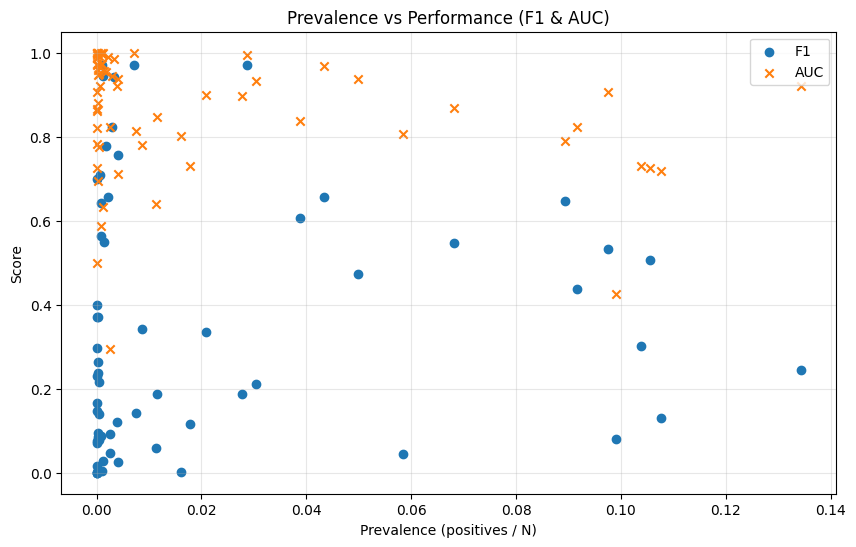

Saved → /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/results_capped_eval/plots/scatter_prevalence_vs_performance.png


In [58]:
plt.figure(figsize=(10, 6))
plt.scatter(df["prevalence"], df["f1"], label="F1")
plt.scatter(df["prevalence"], df["auc"].fillna(0.5), marker="x", label="AUC")
plt.xlabel("Prevalence (positives / N)")
plt.ylabel("Score")
plt.title("Prevalence vs Performance (F1 & AUC)")
plt.grid(alpha=0.3)
plt.legend()

out_path = os.path.join(PLOTS_DIR, "scatter_prevalence_vs_performance.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved →", out_path)
